In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from utils.visualization import visualize_rel_error_report
from utils.data import (
    DATA_SOURCE,
    PROC_SOURCE,
    PRED_SINK,
    MODEL_SINK,
    EXP_CSV_COLS,
    EXP_CSV_PATH,
    TRIALS_CSV_COLS,
    TRIALS_CSV_PATH,
)

VAL_SOURCE = DATA_SOURCE.parent / "validation"
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

IMG_PATH = Path.cwd().parent.parent / 'notebooks' / 'img'
IMG_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
hpo_exp_ids = []

In [3]:
# load up meta info
exp_tab = pd.read_csv(EXP_CSV_PATH, dtype=EXP_CSV_COLS)
trials_tab = pd.read_csv(
    TRIALS_CSV_PATH,
    dtype=TRIALS_CSV_COLS,
    parse_dates=["start_date", "end_date"],
)
# only one row should be returned
meta_info_df = trials_tab.merge(exp_tab, on="experiment_uid")
exp_tab

,experiment_uid,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size
0,f1583,True,8,4,1,True,2,NaN,-1
1,b588e,True,8,4,1,False,2,NaN,-1
2,6af40,True,8,4,1,False,2,NaN,-1
3,2f422,True,8,4,1,True,2,NaN,-1
4,fd0ea,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1
5,cdb55,False,1,64,6,True,10000,p_loss_weigth = i_epoch / N_EPOCHS (no weight!...,-1
6,6a78a,True,8,4,1,True,2,NaN,-1
7,98eec,True,8,4,1,True,2,test_comment,-1
8,c4420,True,8,4,1,True,2,"here, new materials",-1
9,20386,True,8,4,1,True,2,another test,-1


| Description | # Parameters |
| ----------   | --------- |
| no expensive layer | 1135 |
| 8 neurons in expensive layer | 2231 |
| standard topo (24 in expensive) | 4711 |
| 32 in expensive | 5951|
| 32 in expensive and kernel size 17 (instead of 9) | 10943|

In [4]:
meta_info_df.query(f"debug == False").head()

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size
24,fd0ea,A,d33adc5f,0,0,0.020748,0.055306,0.079721,362569.65625,2023-11-27 20:06:14,2023-12-01 20:42:14,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1
25,fd0ea,A,bcd2ac92,0,1,0.020748,0.055306,0.079721,362569.65625,2023-11-27 20:06:14,2023-12-01 20:42:14,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1
26,fd0ea,A,dbe5de2a,0,2,0.020748,0.055306,0.079721,362569.65625,2023-11-27 20:06:14,2023-12-01 20:42:14,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1
27,fd0ea,A,802277ba,0,3,0.020748,0.055306,0.079721,362569.65625,2023-11-27 20:06:14,2023-12-01 20:42:14,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1
28,fd0ea,A,457ddabb,1,0,0.022394,0.055780,0.078674,878033.00000,2023-11-28 00:31:00,2023-12-01 20:42:14,False,1,64,4,True,30000,p_loss_weight = 0.5 * i_epoch / N_EPOCHS,-1


In [7]:
err_info_df = (
    meta_info_df.query(f"debug == False")
    .loc[
        :,
        ["experiment_uid", "material", "model_size"]
        + [c for c in meta_info_df if c.endswith("_err") and c != "max_rel_err"],
    ]
    .melt(
        id_vars=["experiment_uid", "material", "model_size"],
        value_vars=["avg_rel_err", "95-perc_rel_err", "99-perc_rel_err"],
        var_name="Quantile",
        value_name="Error",
    )
    .assign(
        Quantile=lambda x: x.Quantile.map(
            {
                "avg_rel_err": "Average",
                "95-perc_rel_err": "95th",
                "99-perc_rel_err": "99th",
            }
        )
    )
).drop_duplicates()  # eliminate all except one fold since reported err is the same for all folds
err_info_df

,experiment_uid,material,model_size,Quantile,Error
0,fd0ea,A,-1,Average,0.020748
4,fd0ea,A,-1,Average,0.022394
8,fd0ea,A,-1,Average,0.026049
12,fd0ea,B,-1,Average,0.011174
16,fd0ea,B,-1,Average,0.010549
...,...,...,...,...,...
4324,c7d33,E,3662,99th,0.139513
4328,c7d33,E,3662,99th,0.184010
4332,c7d33,E,3662,99th,0.140940
4336,c7d33,E,3662,99th,0.149972


/tmp/ipykernel_6263/3840848545.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_6263/3840848545.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_6263/3840848545.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_6263/3840848545.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_6263/3840848545.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


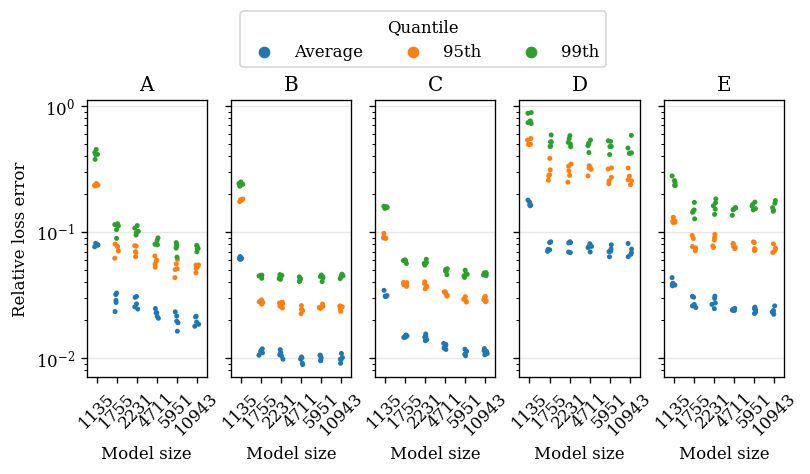

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(7.5, 3), sharey=True)
err_cols = [
    c for c in meta_info_df if c.endswith("rel_err") and not c.startswith("max")
]
expid_l = {
    "75010",
    "58ab3",
    "14abf",
    "ea89c",
    "60642",
    "0a2ef",
}

for ax, (mat_lbl, mat_df) in zip(
    axes.flatten(),
    err_info_df.query(f"experiment_uid in @expid_l").groupby("material"),
):
    # errs = mat_df.loc[:, err_cols].to_numpy().ravel()

    sp = sns.stripplot(
        mat_df,
        x="model_size",
        y="Error",
        hue="Quantile",
        ax=ax,
        size=3,
        legend=True,
    )
    ax.set_ylabel("Relative loss error")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(mat_lbl)
    ax.set_yscale("log")
    ax.set_xlabel("Model size")
    leg = sp.get_legend()
    leg.set_visible(False)
sns.move_legend(
    sp,
    "upper center",
    bbox_to_anchor=(0.4, 1.35),
    ncol=3,
    bbox_transform=axes[2].transAxes,
)

fig.savefig(IMG_PATH / "pareto_front.pdf", dpi=300, bbox_inches="tight")

In [29]:
mat_df.groupby('material')['95-perc_rel_err'].transform('min')

620    0.075416
621    0.075416
622    0.075416
623    0.075416
624    0.075416
625    0.075416
626    0.075416
627    0.075416
628    0.075416
629    0.075416
630    0.075416
631    0.075416
632    0.075416
633    0.075416
634    0.075416
635    0.075416
636    0.075416
637    0.075416
638    0.075416
639    0.075416
Name: 95-perc_rel_err, dtype: float32

In [10]:
# for final paper delivery table
tmp_df = meta_info_df.query("experiment_uid == '58ab3' and fold == 0")
tmp_df.loc[tmp_df.loc[:, '95-perc_rel_err'] == tmp_df.groupby('material')['95-perc_rel_err'].transform('min'), :]

#for mat_lbl, mat_df in meta_info_df.query("experiment_uid == 'ea89c'").groupby('material'):
#    print(mat_df.loc[mat_df.loc[:, '95-perc_rel_err'] == mat_df.loc[:, '95-perc_rel_err'].min(), :])

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size
1340,58ab3,A,f2f15ded,0,0,0.023383,0.061989,0.089049,389973.40625,2023-12-16 12:14:52,2023-12-18 04:18:53,False,1,64,4,True,5000,first cnn layer has minimum neurons followd by...,1755
1360,58ab3,B,1085fa20,0,0,0.010997,0.026826,0.045513,167140.00000,2023-12-16 17:40:36,2023-12-18 04:18:53,False,1,64,4,True,5000,first cnn layer has minimum neurons followd by...,1755
1392,58ab3,C,76461c26,3,0,0.014578,0.036989,0.059355,328585.59375,2023-12-17 18:29:09,2023-12-18 04:18:53,False,1,64,4,True,5000,first cnn layer has minimum neurons followd by...,1755
1408,58ab3,D,d40accf6,2,0,0.070290,0.257627,0.476592,769743.68750,2023-12-17 23:40:52,2023-12-18 04:18:53,False,1,64,4,True,5000,first cnn layer has minimum neurons followd by...,1755
1428,58ab3,E,ea8d57f5,2,0,0.025124,0.070980,0.127102,670233.12500,2023-12-18 01:57:12,2023-12-18 04:18:53,False,1,64,4,True,5000,first cnn layer has minimum neurons followd by...,1755


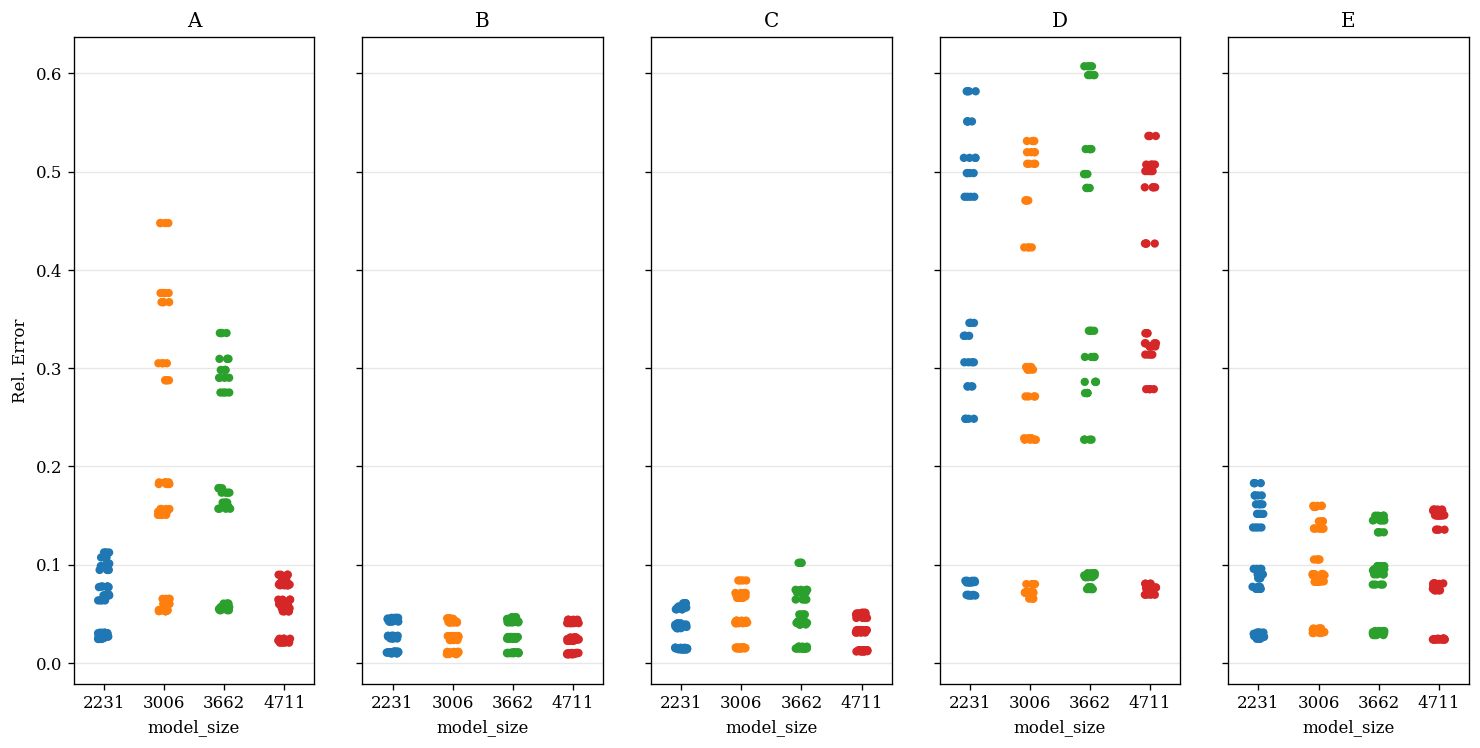

In [7]:
# evaluate FFT features (experimental)
fig, axes = plt.subplots(1, 5, figsize=(15, 7), sharey=True)
err_cols = [
    c for c in meta_info_df if c.endswith("rel_err") and not c.startswith("max")
]
expid_l = {
    "14abf",
    "ea89c",
    "b7cd2","bfd85"
}

for ax, (mat_lbl, mat_df) in zip(
    axes.flatten(),
    meta_info_df.query(
        f"debug == False and experiment_uid in @expid_l"
    ).groupby("material"),
):
    # errs = mat_df.loc[:, err_cols].to_numpy().ravel()
    for c in err_cols:
        sns.stripplot(
            mat_df,
            x="model_size",
            y=c,
            hue="experiment_uid",
            ax=ax,
            legend=False,
        )
    ax.set_ylabel("Rel. Error")
    #ax.text(0.05, 0.9, s=mat_lbl, transform=ax.transAxes, fontdict={'size': 20})
    ax.set_title(mat_lbl)